In [46]:
import os
import glob
import sys
import random
import shutil
import tqdm

# data processing
import tensorflow as tf
import numpy as np
import tetgen
import SimpleITK as sitk
from skimage import measure
from numpy import random
from math import factorial
import numpy as np
from scipy.spatial import distance
from scipy import ndimage
# ploting
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

import scipy
from scipy.optimize import fmin_cg 
from scipy.stats import chi2
from scipy.stats import wasserstein_distance
import skimage
from tensorflow.keras import layers
import pyvista as polyv
from IPython.display import clear_output
import networkx as nx
sys.path.append('./utils/pyOptFEM/')
from pyOptFEM.FEM3D.assembly import *
from pyOptFEM import *

In [2]:
NU = 0.3                          #(0< NU <0.5)
YOUNG_MODULUS = 1
lame_lambda = YOUNG_MODULUS * NU / ((1 + NU) * (1 - 2 * NU))
shear_modulus = YOUNG_MODULUS / (2 * (1 + NU))
lambda_W = 1e-1

In [3]:
NUM_P = '01'
MIN_PYRAMID_LEVEL = 4
NAME = glob.glob('./results/*PATIENT'+str(NUM_P)+'*')[-1]
path_graph = sorted(glob.glob(NAME + '/' + str(MIN_PYRAMID_LEVEL) + '/Output_GRAPH*[!Q]'))[-1]

In [4]:
grid = polyv.read(NAME + '/grid.vtk')
path_graph = sorted(glob.glob(NAME + '/' + str(MIN_PYRAMID_LEVEL) + '/Output_GRAPH*[!Q]'))[-1]
print(path_graph)
Output_GRAPH = nx.read_gpickle(path_graph)

./results/new2EMPIRE10PATIENT01PYR3NODES1021P7Q15E5S30regtns_regAn_Qstep_conditionedROT/4/Output_GRAPH4


In [5]:
grid = polyv.read('grid.vtk')

Output_GRAPH = nx.read_gpickle('Output_GRAPH')

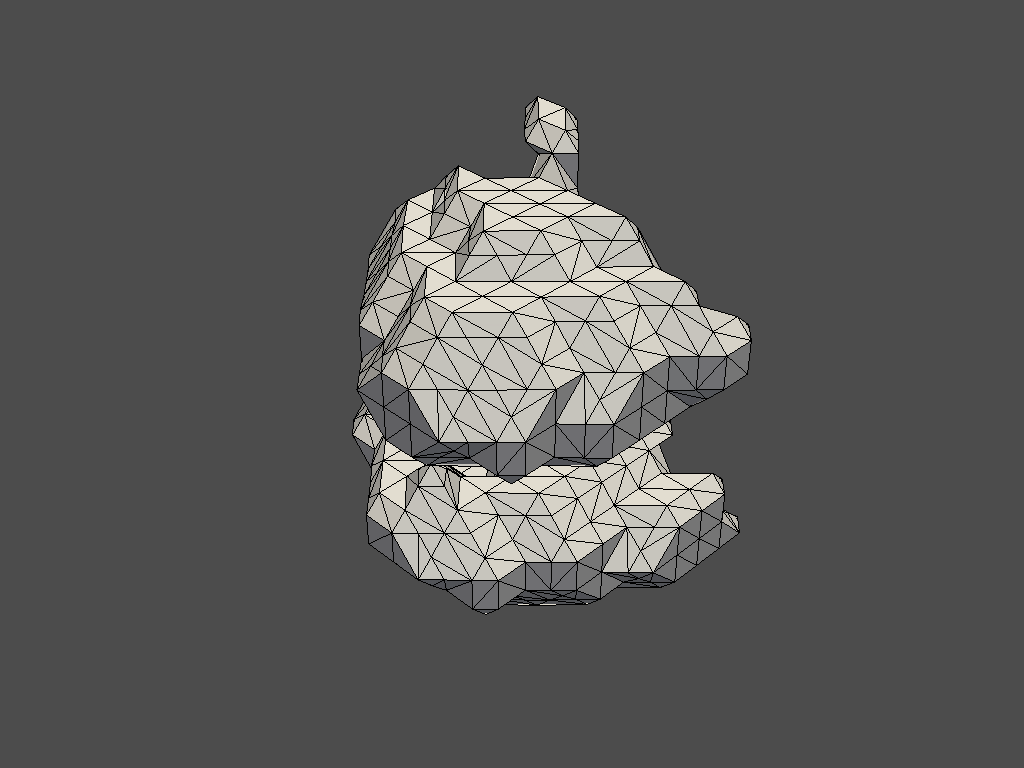

In [5]:
grid.plot(show_edges = True)

In [6]:
grid

UnstructuredGrid,Information
N Cells,4075
N Points,1021
X Bounds,"9.200e+01, 2.970e+02"
Y Bounds,"9.200e+01, 3.380e+02"
Z Bounds,"9.400e+01, 3.670e+02"
N Arrays,0


# Usefull Func

In [7]:
def pyvistamesh_global_stiffness(grid_mesh, lambda_lame, shear_modulus,  Num = 0):
    """
    :param grid_mesh:
    :param lame_Poisson: shear modulus
    :param shear_modulus:
    :return:
    """

    coors = np.array(grid_mesh.points)  #coordinates Th.q
    n_vertices = grid_mesh.n_points  #Th.nq # n_points

    # mat_ids=np.array(grid_mesh.cells)
    conn = np.reshape(grid_mesh.cells, [-1, 5])[:, 1:]  #Th.me # edges

    #Th.q # coordonnées # int
    n_cells = grid_mesh.n_cells  #Th.nme # num cells (tetrahedrons)
    V = np.array(
        [simplex_volume(vertices=coors[conn][_]) for _ in range(n_cells)])  #Th.volumes # volumes des tetraedres

    return StiffElasAssembling3DP1base(n_vertices, n_cells, coors, conn, V, shear_modulus, lambda_lame, Num)

def calc_D_mats(grid):
    ''''
    '''
    cells = grid.cells.reshape(-1, 5)[:, 1:]
    ls_Hinv=[]
    for i in range(cells.shape[0]):
        cell = cells[i]
        Q = grid.points[cell]
        v=simplex_volume(vertices=Q)
        ls_Hinv.append(ComputeGradient(Q).T/(6*v))
    return np.stack(ls_Hinv,axis=0)




In [8]:
def simplex_volume(*, vertices=None, sides=None) -> float:
    """
    Return the volume of the simplex with given vertices or sides.

    If vertices are given they must be in a NumPy array with shape (N+1, N):
    the position vectors of the N+1 vertices in N dimensions. If the sides
    are given, they must be the compressed pairwise distance matrix as
    returned from scipy.spatial.distance.pdist.

    Raises a ValueError if the vertices do not form a simplex (for example,
    because they are coplanar, colinear or coincident).

    Warning: this algorithm has not been tested for numerical stability.
    """

    # Implements http://mathworld.wolfram.com/Cayley-MengerDeterminant.html

    if (vertices is None) == (sides is None):
        raise ValueError("Exactly one of vertices and sides must be given")

    # β_ij = |v_i - v_k|²
    if sides is None:
        vertices = np.asarray(vertices, dtype=float)
        sq_dists = distance.pdist(vertices, metric='sqeuclidean')

    else:
        sides = np.asarray(sides, dtype=float)
        if not distance.is_valid_y(sides):
            raise ValueError("Invalid number or type of side lengths")

        sq_dists = sides ** 2

    # Add border while compressed
    num_verts = distance.num_obs_y(sq_dists)
    bordered = np.concatenate((np.ones(num_verts), sq_dists))

    # Make matrix and find volume
    sq_dists_mat = distance.squareform(bordered)

    coeff = - (-2) ** (num_verts - 1) * factorial(num_verts - 1) ** 2
    vol_square = np.linalg.det(sq_dists_mat) / coeff

    if vol_square <= 0:
        raise ValueError('Provided vertices do not form a tetrahedron')

    return np.sqrt(vol_square)


In [9]:
def estimate_variances_and_means_multivariateGaussian_Unique_nablaQ(Graph):
    '''
    Bayesian estimation of the distributions of :
     - T : along z,y and x using a multivariate t-student distribution
     - An : For the 9 parameters using a multivariate t-student distribution
    Weighting based on the mahalanobis distance (MD) : small MD should be lessed penalized

    '''
    ## for translation
    dist = np.stack(
        [nx.get_node_attributes(Graph, 'translation_from_Pn')[key] for key in range(Graph.number_of_nodes())])
    # pars = np.reshape(np.stack(
    #   [np.ravel(scipy.linalg.logm(nx.get_node_attributes(Graph, 'NablaQ')[key])) for key in range(Graph.number_of_nodes())]),[-1,9])

    #    pars = np.reshape(np.stack(
    #        [nx.get_node_attributes(Graph, 'NablaQ')[key] for key in range(Graph.number_of_nodes())]),[-1,1])
    An = np.stack(
        [nx.get_node_attributes(Graph, 'affines_or')[key][:, :-1] for key in range(Graph.number_of_nodes())])
    NablaQs = np.stack(
        [nx.get_node_attributes(Graph, 'NablaQ')[key] for key in range(Graph.number_of_nodes())])

    global_pars = dist

    pars_means = np.mean(global_pars, axis=0)
    pars_cov = np.cov(global_pars, rowvar=False)

    mahalanobis_distance = (np.diag(
        (np.dot((np.dot((global_pars - pars_means), np.linalg.inv(pars_cov))), (global_pars - pars_means).T)))) ** 0.5
    z = chi2.cdf(mahalanobis_distance, 3)

    tn_mean = pars_means[0:3]
    tn_std = pars_cov.diagonal()[0:3] ** 0.5

    An_mean = np.mean(An, axis=0)
    An_std = (np.sum((An - NablaQs) ** 2) / Graph.number_of_nodes()) ** 0.5

    In_var = np.mean(np.stack(
        [nx.get_node_attributes(Graph, 'MSE')[key] for key in range(Graph.number_of_nodes())]))

    return tn_mean, tn_std, An_mean, An_std, z, pars_cov, In_var, mahalanobis_distance

# Other variables

In [10]:
tn_mean, tn_std, An_mean, An_std, z, pars_cov, In_var, mahalanobis_distance = estimate_variances_and_means_multivariateGaussian_Unique_nablaQ(Output_GRAPH)

In [132]:
n_vertices = grid.points.shape[0]
n_tetrahedron = grid.cells.shape[0]
t_n = np.array([nx.get_node_attributes(Output_GRAPH, 'translation_from_Pn')[_]
                  for _ in range(n_vertices)])  ## translation parameters
Pns = np.array([nx.get_node_attributes(Output_GRAPH, 'Pn')[_]
                for _ in range(n_vertices)])   ## Point P

t_n_vec = (t_n).reshape([-1])                     ## One dimensional vector with x,y,z one after another


In [130]:
sigm_t = 1
sigm_A = 1

# Stiffness Matrix M

In [16]:
S_sparse = pyvistamesh_global_stiffness(grid, lame_lambda, shear_modulus)
# S_dense = scipy.sparse.csr_matrix.todense(S_sparse)
Dmat = calc_D_mats(grid)  # shape N_tetrahedron x 4 x 3


# Stiffness Matrix T

In [128]:
Kt = np.eye(u_Pns_lin.shape[0]) #/ (2 * sigm_t ** 2)
Rt=t_n_vec #/(sigm_t ** 2)
squared_t = np.sum(t_n_vec**2)#/(2*sigm_t ** 2)
import time
t0 = time.time()

reg_tn = np.dot(U.T, kt).dot(U) - np.dot(U.T,Rt) +squared_t
print(reg_tn)
print(time.time()-t0) 

1377922.4022220075
0.004282951354980469


In [129]:
import time
t0 = time.time()
reg_tn = np.sum((U-t_n_vec)**2)#/(2*sigm_t ** 2)
print(reg_tn)
print(time.time()-t0)

1379454.4827862454
0.0003528594970703125


# Stiffness Matrix A

In [33]:
tetrahedrons = np.reshape(grid.cells,[-1,5])[:,1:]

In [35]:
idx_tetra_n = [num_cell
             for num_cell, cell in enumerate(np.reshape(grid.cells, [-1, 5])[:, 1:])
             if any([idx_cell in vertex_number for idx_cell in [*cell]])]

In [37]:
def outer(a):
    '''
    a 1 dimensional vector of size 3
    '''
    outer_a = [[a[0],0,0],
              [0,a[0],0],
              [0,0,a[0]],
              [a[1],0,0],
              [0,a[1],0],
              [0,0,a[1]],
              [a[2],0,0],
              [0,a[2],0],
              [0,0,a[2]]]
    
    return outer_a

In [38]:
Pns = np.array([nx.get_node_attributes(Output_GRAPH,'Pn')[idx] for idx in range(n_vertices)])[:,1:-1]
Qns = np.array([nx.get_node_attributes(Output_GRAPH,'Qn')[idx] for idx in range(n_vertices)])[:,1:-1]


In [39]:
nabla_Q=[]
for num_cell in idx_tetra_n:
    tetrahedron = tetrahedrons[num_cell]
    idx_cell = np.argwhere(tetrahedron == vertex_number[0])[0][0]
    P = Pns[tetrahedron]
    Q = Qns[tetrahedron]

    v = simplex_volume(vertices=P)
    D_mat = ComputeGradient(P).T / (6 * v)
    nablaQ_n = np.einsum('ij,jk->ik',Q.T,D_mat)
    nabla_Q.append(nablaQ_n)
np.mean(np.array(nabla_Q),axis=0)

array([[ 1.76151089, -0.40163674,  0.22846293],
       [-0.09392403,  1.00758101,  0.10720545],
       [ 1.707453  , -1.40820724,  1.41711341]])

In [41]:
def calc_bn(vertex_num,grid):
    tetrahedrons = grid.cells.reshape(-1, 5)[:, 1:]
    Pns = np.array(grid.points)

    # RETURN THE NUMBER OF THE CELLS
    # find the num of tetra
    # if idx_points in cell

    v_i = [num_cell
                 for num_cell, tetra in enumerate(tetrahedrons)
                 if any([idx_cell in [vertex_num] for idx_cell in [*tetra]])]
    c_n = len(v_i)
    
    #print('N TETRA WITH {} : {}'.format(vertex_num,c_n))
 
    ls_Dmat_index_s_i = []
    #ls_Bn_i = []
    list_idx_vertex = np.unique(tetrahedrons[v_i])
    list_idx_vertex_full = tetrahedrons[v_i]

    Bn_mat = np.zeros([len(list_idx_vertex),3])

    for num_tetra,v in enumerate(v_i):            
        ## LOOP WITHIN THETRAHEDRONS
        #print(num_tetra)
        index_vertex_tetra_v = tetrahedrons[v]
        #print(index_vertex_tetra_v)
        P = Pns[index_vertex_tetra_v]
        v = simplex_volume(vertices=P)
        D_mat = ComputeGradient(P).T / (6 * v)
        
        for index_pos_vertex,vertex_idx in enumerate(index_vertex_tetra_v): 
            D_mat_index = D_mat[index_pos_vertex,:] 
            vertex_pos_in_Bn = np.argwhere( vertex_idx == list_idx_vertex)[0][0]
            #print('VERTEX {} POS {}'.format(vertex_idx,vertex_pos_in_Bn))
            #print(D_mat_index)
            Bn_mat[vertex_pos_in_Bn,:] += 1/c_n * D_mat_index
            
            #print(Bn_mat)
            #print(Bn_mat)
    return Bn_mat,list_idx_vertex


In [42]:
nablaQ_n = 0
for idx_vertex in [10]:
    bn_mat,list_vertex_bn_mat = calc_bn(idx_vertex,grid)
for i in range(bn_mat.shape[0]): 
    nablaQ_n+=np.dot(outer(bn_mat[i,:]),Qns[list_vertex_bn_mat[i]]).T   ## a confirmer pour .T

In [43]:
nablaQ_n.reshape([3,3])

array([[ 1.76151089, -0.09392403,  1.707453  ],
       [-0.40163674,  1.00758101, -1.40820724],
       [ 0.22846293,  0.10720545,  1.41711341]])

In [44]:
def find_neighbors(idx_vertex,grid):
    
    tetrahedrons = grid.cells.reshape(-1, 5)[:, 1:]

    # RETURN THE NUMBER OF THE CELLS
    # find the num of tetra
    # if idx_points in cell

    v_i = [num_cell
                 for num_cell, tetra in enumerate(tetrahedrons)
                 if any([idx_cell in [idx_vertex] for idx_cell in [*tetra]])]
    

    list_idx_vertex = np.unique(tetrahedrons[v_i])
    neighbors = set(list_idx_vertex) - set([idx_vertex])
    return neighbors

In [48]:
## In case stiffness matrix in not organized as [x0,x1,x2] but as 
Ka = np.zeros([3*n_vertices,3*n_vertices])
t0 = time.time()
#row,col,val=[],[],[]
#for i in tqdm.tqdm(range(1)):    ##n_vertices

for i in tqdm.tqdm(range(n_vertices)):    ##n_vertices
    neighbors_i = find_neighbors(i,grid)
    neighbors_i_plus = set(list(neighbors_i) + [i])

    for j in range(i,n_vertices):   ##n_vertices
        neighbors_j= find_neighbors(j,grid)
        neighbors_j_plus = set(list(neighbors_j) + [j])
        common_nodes = neighbors_i_plus.intersection(neighbors_j_plus)
        if len(common_nodes)>0:
            kij = 0
            for common_node in common_nodes:
                bn_mat,list_vertex_bn_mat = calc_bn(common_node,grid)
                idx_i_in_bn_mat = np.argwhere(list_vertex_bn_mat==i)[0][0]
                idx_j_in_bn_mat = np.argwhere(list_vertex_bn_mat==j)[0][0]
                #kij+=np.dot(np.matrix(bn_mat[idx_i_in_bn_mat]).T,np.matrix(bn_mat[idx_j_in_bn_mat]))
                kij = np.dot(bn_mat[idx_i_in_bn_mat],bn_mat[idx_j_in_bn_mat]) #/ (sigm_A**2)
                Ka[3*i:3*i+3,3*j:3*j+3] += kij*np.eye(3)
Ka += ((Ka)*(1-np.eye(Ka.shape[0]))).T

100%|██████████| 1021/1021 [1:19:43<00:00,  4.94it/s]


In [50]:
An_i = np.array([nx.get_node_attributes(Output_GRAPH,'affines_or')[key][:,:-1] for key in range(n_vertices)])
#An_i = np.array([np.eye(3) for key in range(n_vertices)])

In [51]:
Rai = []
right_part = []
for i in tqdm.tqdm(range(n_vertices)):
    bn_i,_=calc_bn(i,grid)
    Rai.append(np.sum(np.dot(bn_i,(An_i[i,...].T-np.eye(3))),axis=0)/(sigm_A**2))
    right_part.append((An_i[i,...]-np.eye(3))**2#/(2*sigm_A**2))

100%|██████████| 1021/1021 [00:27<00:00, 37.54it/s]


In [252]:
Ra = np.reshape(Rai,[-1])
1/2* np.sum((Ka.dot(u)).dot(np.matrix(u).T))-np.dot(np.matrix(u),Ra)+np.sum(right_part)

matrix([[130.15960079]])

# Stack Save and visualize

In [250]:
Stiffs_staked = np.stack([np.array(Km),np.array(Kt),np.array(Ka)])

In [253]:
np.save('/Users/paulbd/Documents/Projects/lung_registration/patients/'+NUM_P+"/stiffs_stacked",Stiffs_staked)

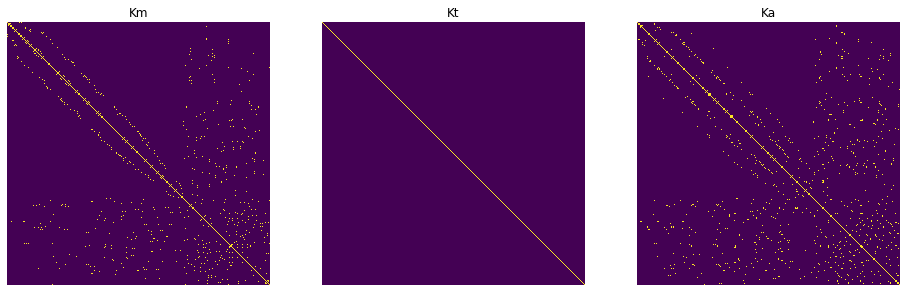

In [254]:
fig,ax=plt.subplots(1,3,figsize=(16,7))
ax[0].imshow(Km!=0)
ax[1].imshow(kt!=0)
ax[2].imshow(Ka!=0)
ax[0].set_axis_off()
ax[0].set_title('Km')
ax[1].set_axis_off()
ax[1].set_title('Kt')
ax[2].set_axis_off()
ax[2].set_title('Ka')

plt.show()

# Q-step

In [98]:
#ka_copy*=(1-np.ee(ka_copy.shape[0]))
u = np.array(u)
std_t = np.std(t_n_vec-u)


In [113]:
u_reshape = u.reshape([-1,3])

In [117]:
Qns_updated = Pns+u_reshape

In [123]:
ls_nablaQ = []
for i in tqdm.tqdm(range(n_vertices)):
    nablaQ_n = 0
    bn_mat,list_vertex_bn_mat = calc_bn(idx_vertex,grid)
    for i in range(bn_mat.shape[0]): 
        nablaQ_n+=np.dot(outer(bn_mat[i,:]),Qns_updated[list_vertex_bn_mat[i]]).T   ## a confirmer pour .T
    ls_nablaQ.append(nablaQ_n.reshape([3,3]))
nablaQ = np.array(ls_nablaQ)

100%|██████████| 1021/1021 [00:08<00:00, 118.21it/s]


In [233]:
std_A = np.std(An_i-nablaQ)

In [234]:
std_A

0.16809716146241313

In [135]:
b = Ra + Rt

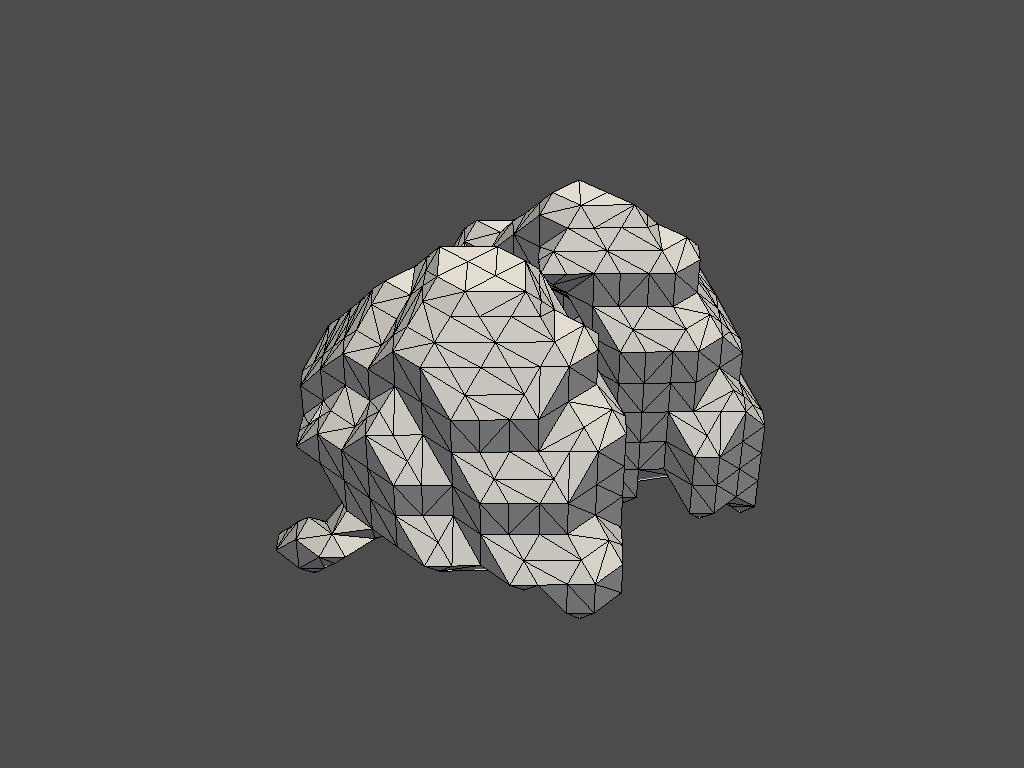

In [225]:
import vtk
cells=np.array(grid.cells)
cell_type=np.array([vtk.VTK_TETRA]*grid.n_cells)
offset=grid.offset
our_permutation = np.argsort([2,1,0])
points=grid.points.copy()

points_natif = points.copy()
points_natif=np.copy(points_natif[:,our_permutation])

grid_initial = polyv.UnstructuredGrid(offset, cells, cell_type, points_natif)
grid_initial.plot(show_edges=True)

In [244]:
matrix_assembly.shape

(3063, 3063)

In [221]:
ls_x = []
for lambda_W in [100,10,1,1e-1,1e-2,1e-3]:
    matrix_assembly = lambda_W*Km + Kt/sigm_t + Ka/sigm_A
    x = np.dot(np.linalg.inv(np.matrix(matrix_assembly)),b)
    ls_x.append(x)

In [224]:
grid_initial_copy.points

pyvista_ndarray([[110.38335826, 282.10785288,  59.06793914],
                 [110.89451857, 301.80967269,  74.03254463],
                 [113.23626263, 280.28967165,  70.79116849],
                 ...,
                 [179.70467109, 110.30018467, 208.58104483],
                 [188.0443949 , 145.00537395, 207.0426824 ],
                 [182.74094946, 116.47827885, 172.04311325]])

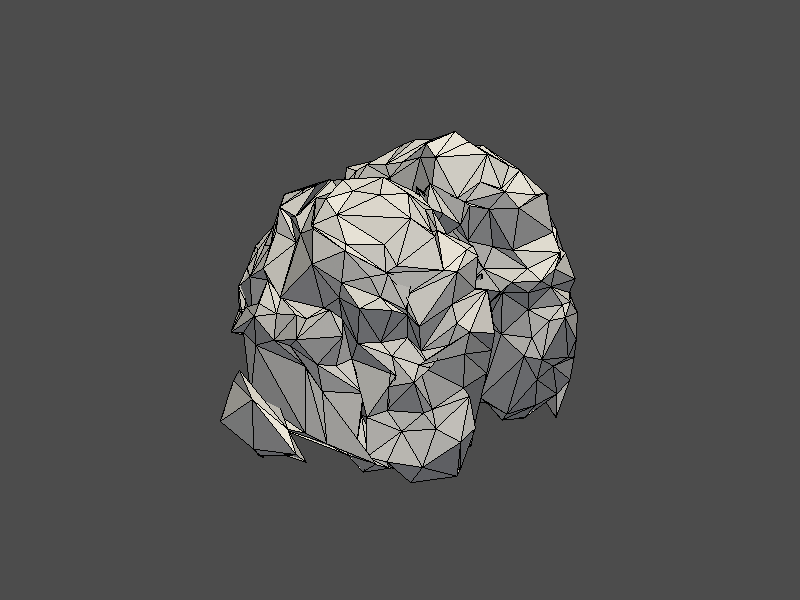

In [227]:

plotter = polyv.Plotter()
#scal = np.linalg.norm(to_Qn_permuted[:,-1,:],axis=1)
plotter.add_mesh(grid_initial_copy,
              show_edges=True) #,
#plotter.add_mesh(grid_initial, 'r', 'wireframe',
#              show_edges=True, 
#              interpolate_before_map=True) #,
plotter.add_axes()

plotter.show(interactive=False, auto_close=False, window_size=[800, 600])
name='PATIENT'+NUM_P+'.gif'
# open movie file.  A mp4 file can be written instead.  Requires moviepy
plotter.open_gif(name)  # or beam.mp4

# Modify position of the beam cyclically

for i in range(len(ls_x)):
    u_i = ls_x[-i].reshape([-1,3])
    u_i=u_i[:,our_permutation]
    #lamb=1 / 2 * np.sum((S_sparse.dot(u_reshape)).dot(np.matrix(u_reshape).T))
    #ls_lamb.append(lamb)
    plotter.update_coordinates(points_natif + u_i)
    plotter.write_frame()

# Close the movie and plot
plotter.close()

In [136]:
matrix_assembly = lambda_W*Km + Kt/sigm_t + Ka/sigm_A

In [143]:
## aim to solve ax = b where a = matrix assembly and b = Rt + Ra
x = np.dot(np.linalg.inv(np.matrix(matrix_assembly)),b)

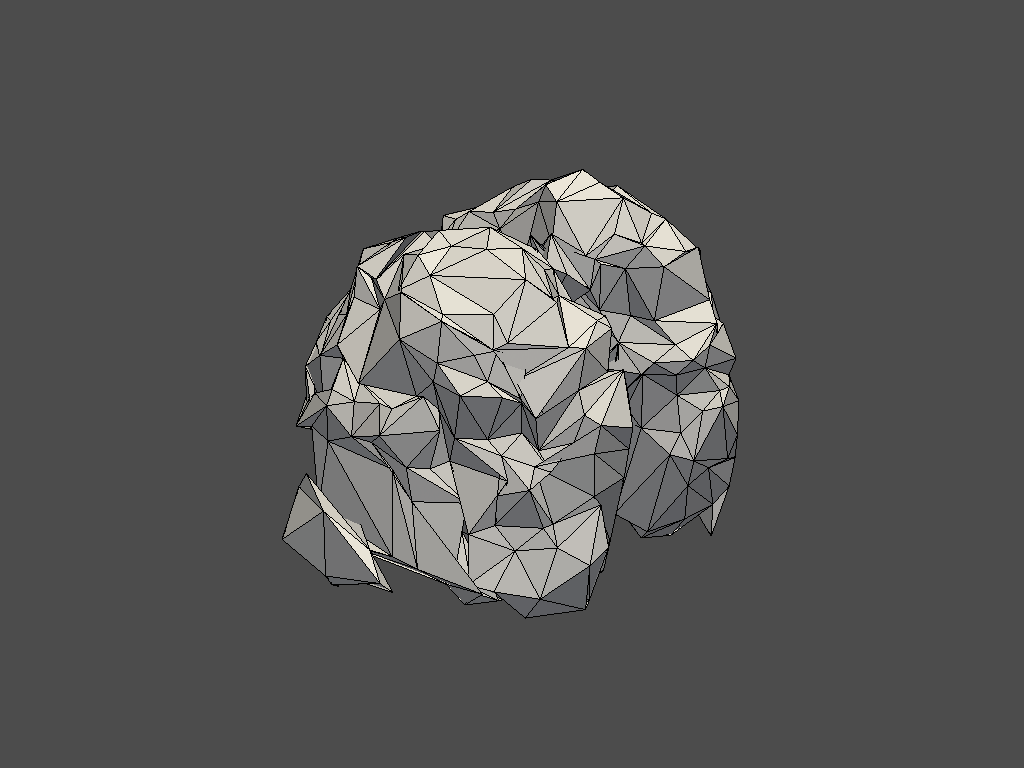

In [197]:
points_t_step = points.copy()
points_t_step+=t_n_vec.reshape([-1,3])
points_t_step=np.copy(points_t_step[:,our_permutation])


grid_after_T = polyv.UnstructuredGrid(offset, cells, cell_type, points_t_step)
grid_after_T.plot(show_edges=True)

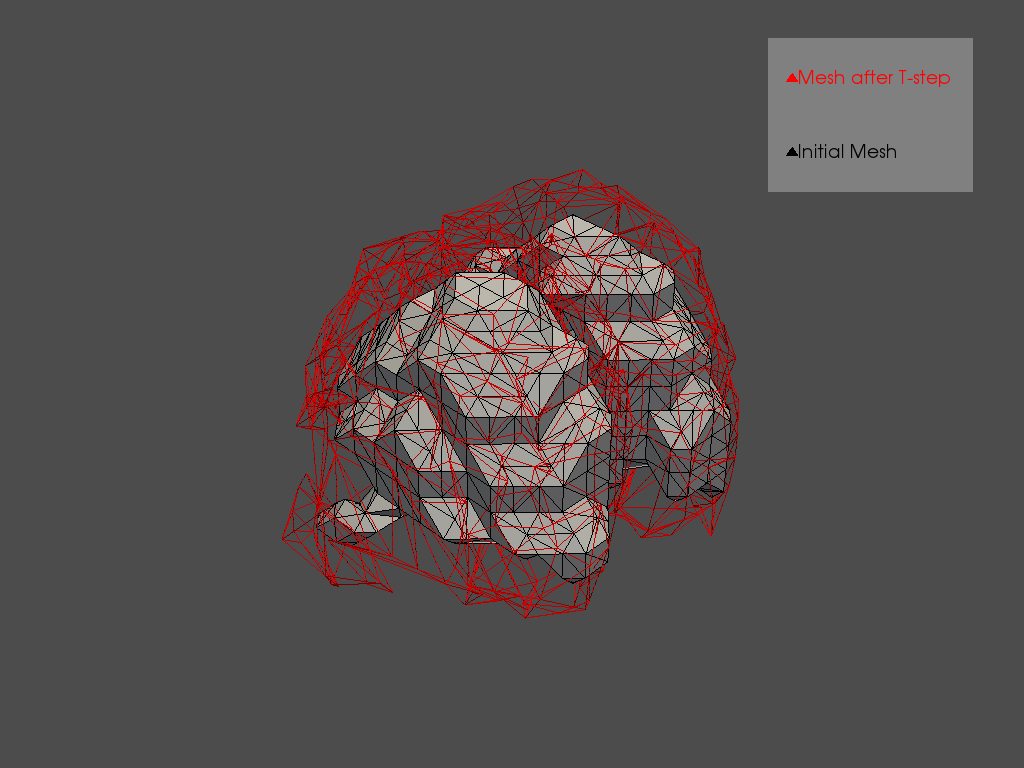

In [202]:
plotter = polyv.Plotter()
plotter.add_mesh(grid_initial, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(grid_after_T, 'r', 'wireframe')
plotter.add_legend([['Mesh after T-step ', 'r'],
cplotter.show()

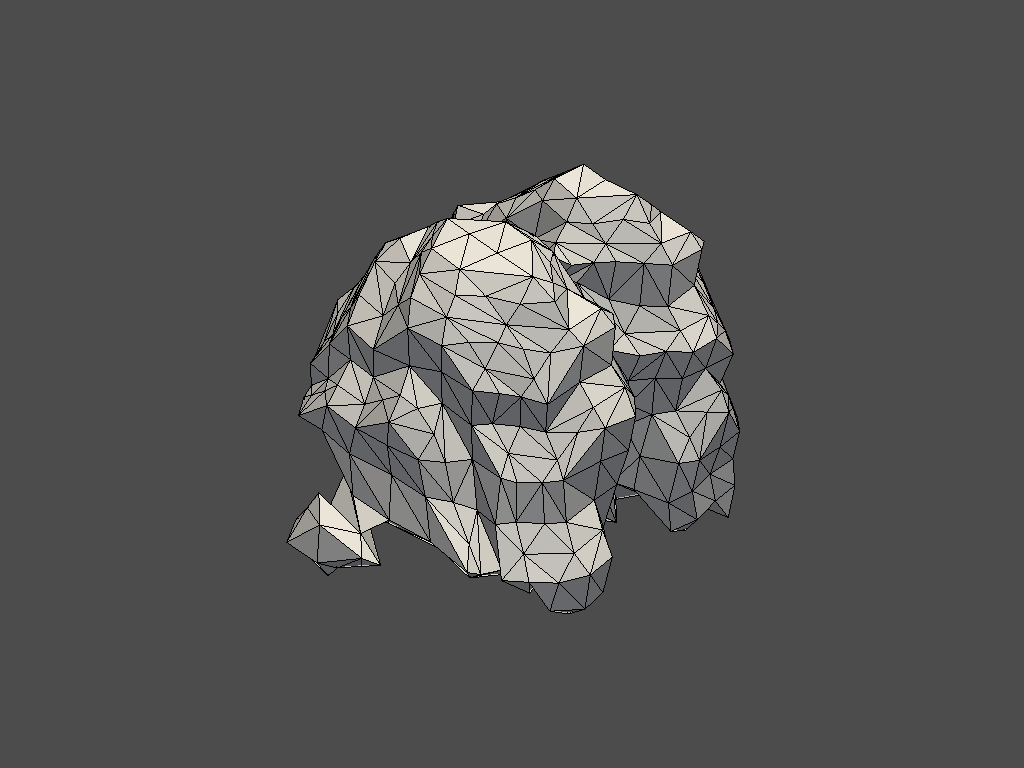

In [198]:
points_q_step = points.copy()
points_q_step+=x.reshape([-1,3])
points_q_step=np.copy(points_q_step[:,our_permutation])

grid_after_Q = polyv.UnstructuredGrid(offset, cells, cell_type, points_q_step)
grid_after_Q.plot(show_edges=True)

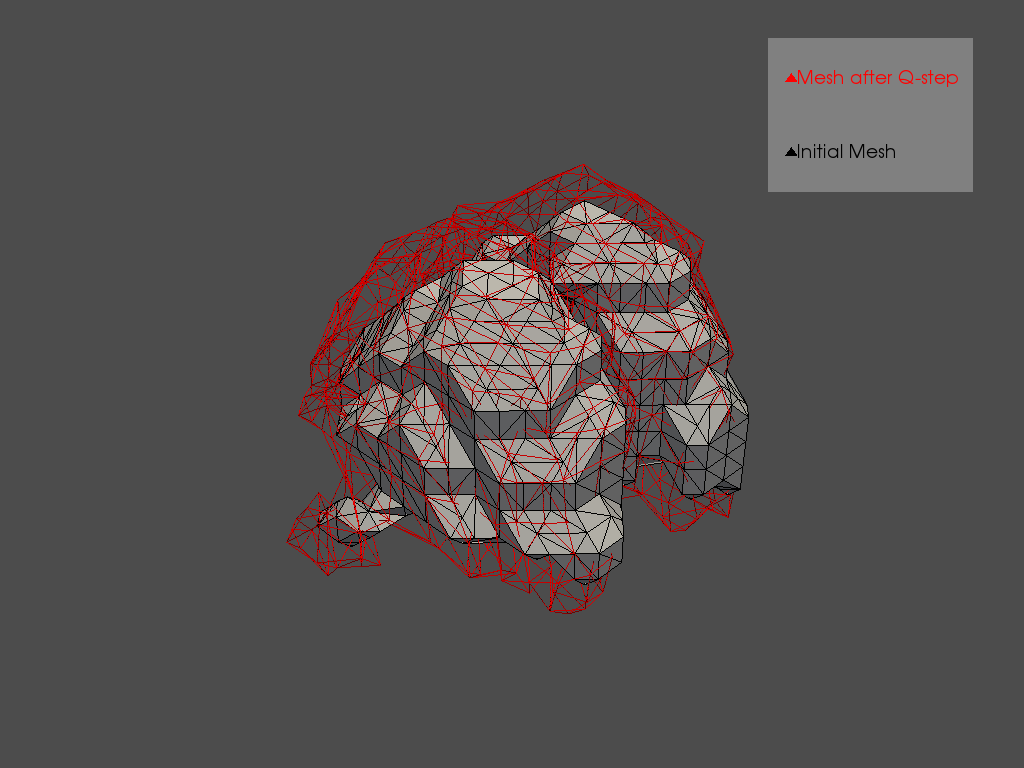

In [228]:
plotter = polyv.Plotter()
plotter.add_mesh(grid_initial, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(grid_after_Q, 'r', 'wireframe')
plotter.add_legend([['Mesh after Q-step ', 'r'],
                    ['Initial Mesh  ', 'black']])
plotter.show()